In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [14]:
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import os
from PIL import Image

import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


We always check that we are running on a GPU

In [15]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))
# print(torch.cuda.memory_usage(0))

The code will run on GPU.
Tesla V100-PCIE-32GB


In [16]:
ROOT_PATH = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = ROOT_PATH + '/' + 'annotations.json'

In [19]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Read annotations

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [24]:
class CocoDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self, root, annFile, transform=None, target_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [43]:
# for i, patch in enumerate(patches):
#     patches[i] = cv2.resize(patch, (128, 128))

# plt.imshow(patches[0])
#coco = COCO(anns_file_path)
#cat_ids_2_supercat_ids = {}
#for cat in categories:
#    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]
#img_ids = coco.getImgIds()
#img_data = coco.loadImgs(img_ids)

batch_size = 1
train_dataset = CocoDetection(ROOT_PATH,anns_file_path)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=lambda x: x)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [45]:
a = next(iter(train_dl))

In [62]:
print(a[0][1][0])

{'id': 1425, 'image_id': 400, 'category_id': 36, 'segmentation': [[1475, 2923, 1520, 2900, 1586, 2768, 1773, 2560, 1892, 2436, 1997, 2351, 2045, 2290, 2143, 2151, 2335, 1957, 2531, 1757, 2797, 1513, 2990, 1332, 3037, 1310, 3099, 1319, 3151, 1330, 3260, 1337, 3297, 1333, 3526, 1347, 3549, 1342, 3650, 1185, 3635, 1117, 3600, 1033, 3578, 955, 3531, 768, 3465, 538, 3402, 528, 3349, 502, 3293, 475, 3130, 387, 2999, 316, 2901, 261, 2779, 197, 2757, 252, 2756, 290, 2723, 378, 2694, 440, 2691, 480, 2669, 527, 2682, 536, 2652, 602, 2612, 671, 2739, 781, 2788, 813, 2835, 843, 2928, 906, 3042, 957, 3118, 983, 2978, 1148, 2929, 1167, 2917, 1170, 2649, 1022, 2583, 953, 2527, 1019, 2463, 1101, 2365, 1204, 2288, 1237, 2179, 1320, 2169, 1370, 2155, 1394, 2137, 1422, 2068, 1487, 1998, 1564, 1893, 1687, 1735, 1847, 1592, 2005, 1553, 2060, 1486, 2121, 1437, 2200, 1306, 2442, 1303, 2492, 1328, 2576, 1377, 2698, 1456, 2882]], 'area': 1761106.5, 'bbox': [1303.0, 197.0, 2347.0, 2726.0], 'iscrowd': 0}


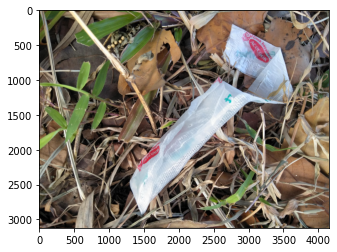

In [50]:
plt.imshow(a[0][0])